In [1]:
import pandas as pd

# Load and clean arrest data
arrest_data = pd.read_csv("arrestdata.tsv", sep="\t")
arrest_data['INCIDENTNEIGHBORHOOD'] = arrest_data['INCIDENTNEIGHBORHOOD'].replace({
    'Mt. Oliver Boro': 'Mt. Oliver',
    'Mt. Oliver Neighborhood': 'Mt. Oliver',
    'Mount Oliver': 'Mt. Oliver',
    'Troy Hill-Herrs Island': 'Troy Hill'
})

# Calculate counts and rankings for arrests
arrest_counts = arrest_data['INCIDENTNEIGHBORHOOD'].value_counts().sort_values()
arrest_rankings = arrest_counts.reset_index()
arrest_rankings.columns = ['Neighborhood', 'Arrest_Count']
arrest_rankings['Arrest_Rank'] = arrest_rankings['Arrest_Count'].rank(ascending=True, method='min')

# Load and clean fire data
fires_data = pd.read_csv("Fires.tsv", sep="\t")
fires_data['neighborhood'] = fires_data['neighborhood'].replace({'Mount Oliver Borough': 'Mt. Oliver'})
fires_data = fires_data.rename(columns={'neighborhood': 'Neighborhood'})

# Calculate counts and rankings for fires
fire_counts = fires_data['Neighborhood'].value_counts()
fire_rankings = fire_counts.reset_index()
fire_rankings.columns = ['Neighborhood', 'Fire_Count']
fire_rankings['Fire_Rank'] = fire_rankings['Fire_Count'].rank(ascending=True, method='min')

# Load third dataset and clean neighborhood names
order_data = pd.read_csv('PI.tsv', sep='\t')
order_data['INCIDENTNEIGHBORHOOD'] = order_data['INCIDENTNEIGHBORHOOD'].replace({
    'Mt. Oliver Boro': 'Mt. Oliver',
    'Mount Oliver': 'Mt. Oliver',
    'Mt. Oliver Neighborhood': 'Mt. Oliver'
})

# Convert 'INCIDENTTRACT' to numeric, handling non-numeric values
order_data['INCIDENTTRACT'] = pd.to_numeric(order_data['INCIDENTTRACT'], errors='coerce')

# Calculate the mean of 'INCIDENTTRACT' for each neighborhood
mean_incidenttract_by_neighborhood = order_data.groupby('INCIDENTNEIGHBORHOOD')['INCIDENTTRACT'].mean()
sorted_mean_incidenttract = mean_incidenttract_by_neighborhood.sort_values().reset_index()
sorted_mean_incidenttract.columns = ['Neighborhood', 'Mean_Incidents']
sorted_mean_incidenttract['Incidents_Rank'] = sorted_mean_incidenttract['Mean_Incidents'].rank(ascending=True, method='min')

# Load speed data
speed = pd.read_csv("Speed.tsv", sep="\t")

#Calcuate rankings for speed
speed['speed_limit'] = pd.to_numeric(speed['speed_limit'], errors='coerce')
mean_speed = speed.groupby('neighborhood')['speed_limit'].mean().dropna().reset_index()
mean_speed.columns = ['Neighborhood', 'Mean_Speed']
mean_speed['Speed_Rank'] = mean_speed['Mean_Speed'].rank(ascending=True, method='min')

# Merge data sets and remove any neighborhoods that don't show up in every dataset
merged_rankings = pd.merge(arrest_rankings, fire_rankings, on="Neighborhood", how="inner")
merged_rankings = pd.merge(merged_rankings, sorted_mean_incidenttract[['Neighborhood', 'Incidents_Rank']], on="Neighborhood", how="inner")
merged_rankings = pd.merge(merged_rankings, mean_speed[['Neighborhood', 'Speed_Rank']], on="Neighborhood", how="inner")

# Calculate the average ranking
merged_rankings['Average_Rank'] = merged_rankings[['Arrest_Rank', 'Fire_Rank', 'Incidents_Rank', 'Speed_Rank']].mean(axis=1)

# Sort by Average Rank in ascending order
merged_rankings = merged_rankings.sort_values(by='Average_Rank').reset_index(drop=True)
merged_rankings.index = merged_rankings.index + 1

# Display the final sorted rankings
pd.set_option('display.max_rows', None)
print(merged_rankings[['Neighborhood', 'Fire_Rank', 'Arrest_Rank', 'Incidents_Rank', 'Speed_Rank', 'Average_Rank']])


                 Neighborhood  Fire_Rank  Arrest_Rank  Incidents_Rank  \
1               Regent Square        1.0          2.0            35.0   
2                   St. Clair        6.0          8.0            43.0   
3                 Polish Hill       24.0         20.0            14.0   
4                  Friendship       22.0         22.0            17.0   
5                 Morningside       23.0         23.0            21.0   
6         Lower Lawrenceville       38.0         32.0            15.0   
7             Stanton Heights       37.0         28.0            22.0   
8                  Upper Hill       30.0         46.0            12.0   
9                West Oakland       41.0         43.0             6.0   
10                Summer Hill       11.0         11.0            77.0   
11           Duquesne Heights       25.0         25.0            50.0   
12             Strip District       46.0         53.0             3.0   
13         Point Breeze North       32.0         33

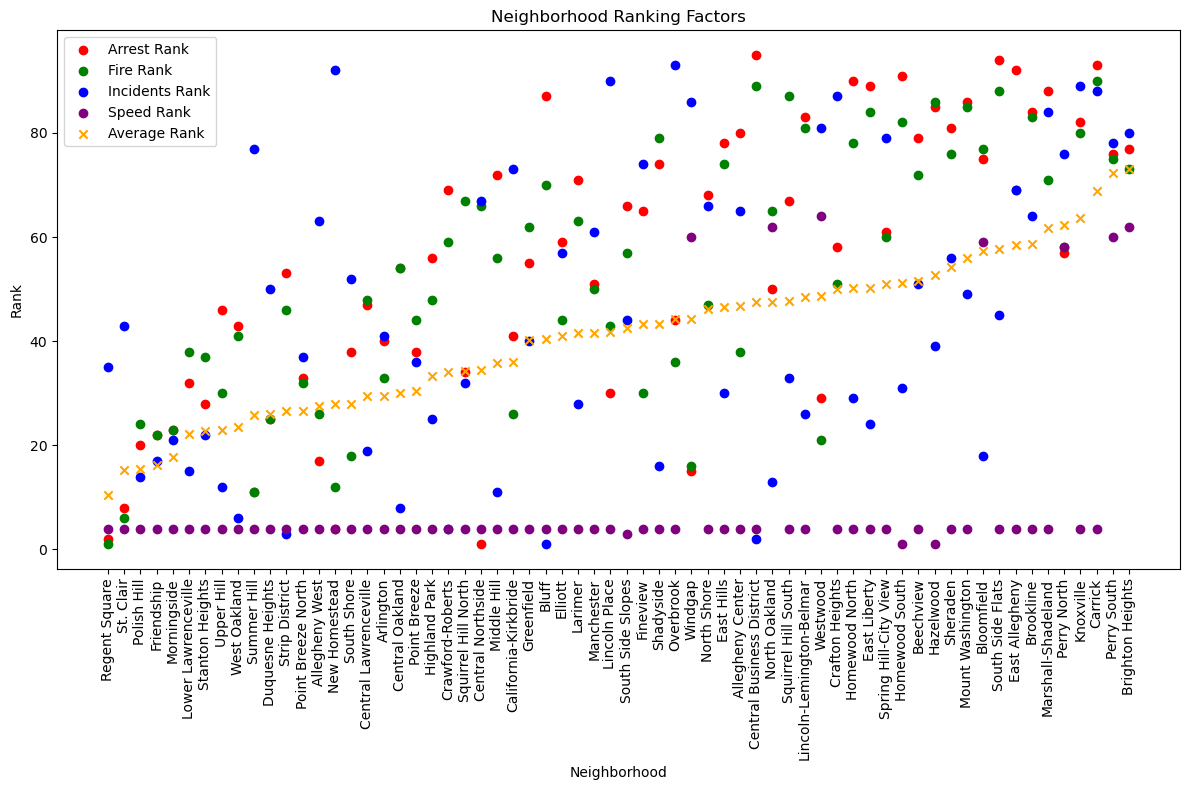

In [2]:
import matplotlib.pyplot as plt
# Scatter plot of different rankings
plt.figure(figsize=(12, 8))

# Plot each rank factor against neighborhoods
plt.scatter(merged_rankings['Neighborhood'], merged_rankings['Arrest_Rank'], color='red', label='Arrest Rank')
plt.scatter(merged_rankings['Neighborhood'], merged_rankings['Fire_Rank'], color='green', label='Fire Rank')
plt.scatter(merged_rankings['Neighborhood'], merged_rankings['Incidents_Rank'], color='blue', label='Incidents Rank')
plt.scatter(merged_rankings['Neighborhood'], merged_rankings['Speed_Rank'], color='purple', label='Speed Rank')
plt.scatter(merged_rankings['Neighborhood'], merged_rankings['Average_Rank'], color='orange', label='Average Rank', marker='x')

# Label and rotate for clarity
plt.xlabel('Neighborhood')
plt.ylabel('Rank')
plt.xticks(rotation=90)
plt.title('Neighborhood Ranking Factors')
plt.legend()
plt.tight_layout()
plt.show()
